In [1]:
import json
import os
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import json
import cv2
import matplotlib.image
from glob import glob
import torch
from model_factory import get_model
import argparse
from model_factory import UNet

In [2]:
"""configurations"""
device = torch.device("cuda:0")

class Test():
    def __init__(self, model_name) -> None:
        self.dilation = False
        self.resize = True
        self.config = None
        name = model_name
        self.name = name
        f = open('/root/autoencoder_denoiser/configs/'+ name + '.json')
        self.config = json.load(f)
        experiment_dir = f"/root/autoencoder_denoiser/results_new_SNR/{name}/"
        state_dict = torch.load(os.path.join(experiment_dir, 'latest_model.pt'))
        model = get_model(self.config)
        try:
            model.load_state_dict(state_dict['model'])
            model = torch.nn.DataParallel(model)
        except:
            model = torch.nn.DataParallel(model)
            model.load_state_dict(state_dict['model'])
            
        model.to(device)
        model.eval()
        self.model = model

        
my_model_test = Test("t1_03")
paper_1d_test = Test("paper_1d")




model :UNet
model: Unet config as the paper indicated)


In [3]:
# img_dir = "/root/autoencoder_denoiser/dataset/real_img_referral_for_testing"
# clean_dir = os.path.join(img_dir, "real_hsqc_clean")
# noisy_dir = os.path.join(img_dir, "real_hsqc_noisy")
# criterion = torch.nn.MSELoss()
# clist = [(0,"darkblue"), (0.5,"white"), (1, "darkred")]
# custom_HSQC_cmap = matplotlib.colors.LinearSegmentedColormap.from_list("_",clist)

# for img_path in glob(noisy_dir+"/*"):
#     img = Image.open(img_path)
#     img = np.array(img)
    
#     plt.imshow(img,cmap=custom_HSQC_cmap, vmax=1, vmin=-1)
#     plt.figure()
    
#     # print(img.shape)
#     plus = 1-img[:,:, 0]/255 # I will assume this is plus but not sure
#     minus = 1-img[:,:, 2]/255
#     # print(plus.shape)
#     img_result = plus-minus
#     resized = cv2.resize(img_result.astype("float32"), (120, 180))
#     img_input = torch.tensor(img_result).unsqueeze(0).unsqueeze(0).float().to(device)
    
#     gound_path = img_path.replace("real_hsqc_noisy","real_hsqc_clean").replace("_HSQC_noisy","_HSQC_original")
#     gound_path = gound_path[:-5] + '1.png'
#     print(gound_path)
#     img = Image.open(gound_path)
#     img = np.array(img)
#     plus_groud = 1-img[:,:, 0]/255 # I will assume this is plus but not sure
#     minus_groud = 1-img[:,:, 2]/255
#     groud_truth = plus_groud - minus_groud
    
#     plt.imshow(groud_truth,cmap=custom_HSQC_cmap, vmax=1, vmin=-1)
#     plt.figure()
#     groud_truth = torch.tensor(groud_truth).unsqueeze(0).unsqueeze(0).float().to(device)
#     # print(img_input.shape)
    
#     denoised_1 = my_model_test.model.forward(img_input)
#     loss_1 = criterion(denoised_1,groud_truth )
#     denoised_1 = denoised_1[0,0].cpu().detach().numpy()   
#     plt.imshow(denoised_1,cmap=custom_HSQC_cmap, vmax=1, vmin=-1)
#     plt.figure()
#     denoised_2 = paper_1d_test.model.forward(img_input)
#     loss_2 = criterion(denoised_2,groud_truth )
#     denoised_2 = denoised_2[0,0].cpu().detach().numpy()  
#     plt.imshow(denoised_2,cmap=custom_HSQC_cmap, vmax=1, vmin=-1)
#     plt.figure()
    
#     print(f"loss of my_model is {loss_1} and previous paper model is {loss_2}")
#     break
    
# img_path

In [4]:
# img_dir = "/root/autoencoder_denoiser/dataset/real_img_referral_for_testing"
# clean_dir = os.path.join(img_dir, "real_hsqc_clean")
# noisy_dir = os.path.join(img_dir, "real_hsqc_noisy")
# criterion = torch.nn.MSELoss()
# clist = [(0,"darkblue"), (0.5,"white"), (1, "darkred")]
# custom_HSQC_cmap = matplotlib.colors.LinearSegmentedColormap.from_list("_",clist)

# for img_path in glob(noisy_dir+"/*"):
#     img = Image.open(img_path)
#     img = np.array(img)
    
#     plt.imshow(img,cmap=custom_HSQC_cmap, vmax=1, vmin=-1)
#     plt.figure()
    
#     '''input'''
#     # print(img.shape)
#     plus = 1-img[:,:, 0]/255 # I will assume this is plus but not sure
#     minus = 1-img[:,:, 2]/255
#     # print(plus.shape)
#     img_result = plus-minus
#     resized = cv2.resize(img_result.astype("float32"), (120, 180))
#     img_input = torch.tensor(resized).unsqueeze(0).unsqueeze(0).float().to(device)
#     plt.imshow(resized,cmap=custom_HSQC_cmap, vmax=1, vmin=-1)
#     plt.figure()
#     print(resized[resized<0])
    
#     '''ground truth'''
#     gound_path = img_path.replace("real_hsqc_noisy","real_hsqc_clean").replace("_HSQC_noisy","_HSQC_original")
#     gound_path = gound_path[:-5] + '1.png'
#     print(gound_path)
#     img = Image.open(gound_path)
#     img = np.array(img)
#     plus_groud = 1-img[:,:, 0]/255 # I will assume this is plus but not sure
#     minus_groud = 1-img[:,:, 2]/255
#     ground_truth = plus_groud - minus_groud
#     ground_truth = cv2.resize(ground_truth.astype("float32"), (120, 180))
    
#     plt.imshow(ground_truth,cmap=custom_HSQC_cmap, vmax=1, vmin=-1)
#     plt.figure()
#     ground_truth = torch.tensor(ground_truth).unsqueeze(0).unsqueeze(0).float().to(device)
#     # print(img_input.shape)
    
#     '''denoised 1 and 2'''
#     denoised_1 = my_model_test.model.forward(img_input)
#     loss_1 = criterion(denoised_1,ground_truth )
#     denoised_1 = denoised_1[0,0].cpu().detach().numpy()   
#     plt.imshow(denoised_1,cmap=custom_HSQC_cmap, vmax=1, vmin=-1)
#     plt.figure()
#     denoised_2 = paper_1d_test.model.forward(img_input)
#     loss_2 = criterion(denoised_2,ground_truth )
#     denoised_2 = denoised_2[0,0].cpu().detach().numpy()  
#     plt.imshow(denoised_2,cmap=custom_HSQC_cmap, vmax=1, vmin=-1)
#     plt.figure()
#     # print(my_model_test.model.module.inc.double_conv[0].weight.data)

#     print(f"loss of my_model is {loss_1} and previous paper model is {loss_2}")
#     break
    
# img_path

100%|██████████| 21/21 [00:05<00:00,  3.99it/s]


test loader size: 42
loss of my_model is 81.45307922363281 and previous paper model is 130.56414794921875


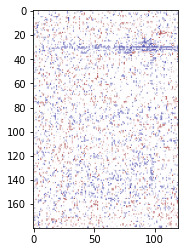

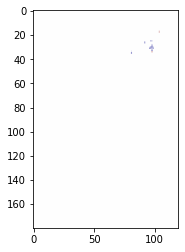

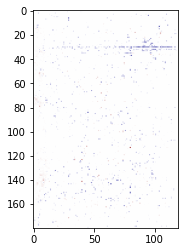

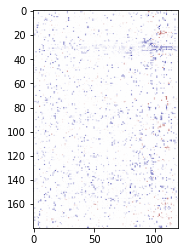

<Figure size 432x288 with 0 Axes>

In [6]:
from hsqc_dataset import *
from tqdm import tqdm
config = my_model_test.config
batch = config["dataset"]['batch_size']
shuffle=config["dataset"]['shuffle']

test_loader = DataLoader(RealNoiseDataset_Byeol(config), batch_size=2, shuffle=False, num_workers=1)

criterion = torch.nn.MSELoss(reduction="sum")
clist = [(0,"darkblue"), (0.5,"white"), (1, "darkred")]
custom_HSQC_cmap = matplotlib.colors.LinearSegmentedColormap.from_list("_",clist)



def test(my_model_test, paper_1d_test):
    displayed=False
    display_num = 0
    loss_1, loss_2= 0, 0
    with torch.no_grad():
        for iter, data in enumerate(tqdm(test_loader)):
            img_input , ground_truth  = data
            # print(img_input)
        # print(ground_truth.shape)                
            
            img_input_tensor = img_input.unsqueeze(1).float().to(device)
            ground_truth_tensor = ground_truth.unsqueeze(1).float().to(device)
        
            '''denoised 1 and 2'''
            denoised_1 = my_model_test.model.forward(img_input_tensor)
        # print(denoised_1.shape)
        # print(ground_truth.shape)
            loss_1 += criterion(denoised_1,ground_truth_tensor )
        
            denoised_2 = paper_1d_test.model.forward(img_input_tensor)
            loss_2 += criterion(denoised_2,ground_truth_tensor )
        
            if not displayed:
            # print(my_model_test.model.module.inc.double_conv[0].weight.data)
                plt.imshow(img_input[1],cmap=custom_HSQC_cmap, vmax=1, vmin=-1)
                plt.figure()
                plt.imshow(ground_truth[1],cmap=custom_HSQC_cmap, vmax=1, vmin=-1)
                plt.figure()
                
                denoised_1 = denoised_1[1,0].cpu().detach().numpy()   
                denoised_2 = denoised_2[1,0].cpu().detach().numpy()  
                plt.imshow(denoised_1,cmap=custom_HSQC_cmap, vmax=1, vmin=-1)
                plt.figure()
                plt.imshow(denoised_2,cmap=custom_HSQC_cmap, vmax=1, vmin=-1)
                plt.figure()
                displayed = True
                # print(loss_1)
                
            # '''save pictures'''
            # for i in range(len(img_input)):
            #     display_num+=1
            #     plt.clf()

            #     ax = plt.subplot(2, 2, 1)
            #     plt.tight_layout()
            #     ax.set_title('original')
            #     ax.axis('off')
            #     plt.imshow(ground_truth[1],cmap=custom_HSQC_cmap, vmax=1, vmin=-1)

            #     ax = plt.subplot(2, 2, 2)
            #     plt.tight_layout()
            #     ax.set_title('noise')
            #     ax.axis('off')
            #     plt.imshow(img_input[i],cmap=custom_HSQC_cmap, vmax=1, vmin=-1)

            #     ax = plt.subplot(2, 2, 3)
            #     plt.tight_layout()
            #     ax.set_title(f'predicted by {my_model_test.name}')
            #     ax.axis('off')
            #     plt.imshow(denoised_1[i,0].cpu().detach().numpy() .cpu(),cmap=custom_HSQC_cmap, vmax=1, vmin=-1)
                
            #     ax = plt.subplot(2, 2, 3)
            #     plt.tight_layout()
            #     ax.set_title(f'predicted by {paper_1d_test.name}')
            #     ax.axis('off')
            #     plt.imshow(denoised_2[i,0].cpu().detach().numpy() .cpu(),cmap=custom_HSQC_cmap, vmax=1, vmin=-1)
                

            #     test_samples_path = ''
            #     plt.savefig(os.path.join(test_samples_path, f"sample_image{}.png"))


                
        
        loss_2 /= len(test_loader.dataset)    
        loss_1 /= len(test_loader.dataset)    
        print("test loader size:" , len(test_loader.dataset))
        print(f"loss of my_model is {loss_1} and previous paper model is {loss_2}")
test(my_model_test, paper_1d_test)

    
    

model: Adv_Unet


100%|██████████| 21/21 [00:03<00:00,  5.59it/s]


test loader size: 42
loss of my_model is 34.1026725769043 and previous paper model is 130.56414794921875


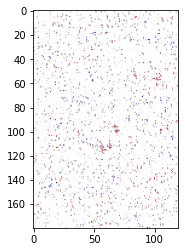

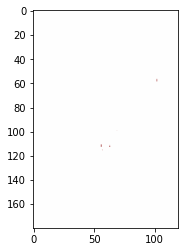

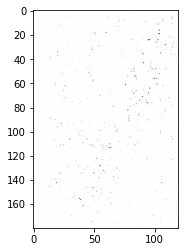

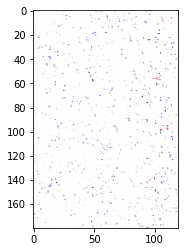

<Figure size 432x288 with 0 Axes>

In [ ]:
finetune_test = Test("t1_03_finetune")

test(finetune_test, paper_1d_test)


model: Adv_Unet


100%|██████████| 21/21 [00:03<00:00,  5.86it/s]


test loader size: 42
loss of my_model is 36.358577728271484 and previous paper model is 130.56414794921875


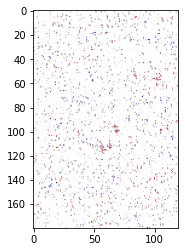

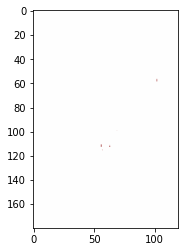

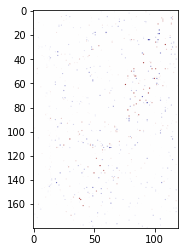

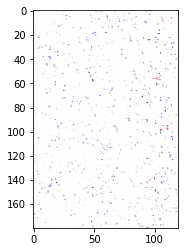

<Figure size 432x288 with 0 Axes>

In [ ]:
finetune_test_5 = Test("t1_03_finetune_5epoch")
test(finetune_test_5, paper_1d_test)



False
tensor(0.4126, device='cuda:0')
tensor(0.4126, device='cuda:0')


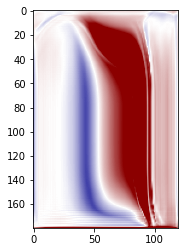

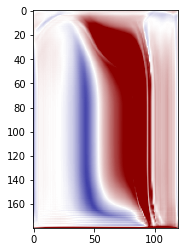

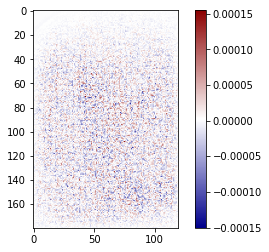

<Figure size 432x288 with 0 Axes>

In [ ]:
# img1 = torch.ones((99,1,180,120))
# img2 = torch.ones((4,1,180,120))

# my_model_test.model.eval()
# torch.use_deterministic_algorithms(True)
# # for i in range(20):
# with torch.no_grad():
#     img1, img2 = img1.to(device), img2.to(device)

#     reulst1 = my_model_test.model(img1)
#     reulst2 = my_model_test.model(img2)

#     plt.imshow(reulst1[0,0].detach().cpu(),cmap=custom_HSQC_cmap, vmax=1, vmin=-1)
#     plt.figure()

#     plt.imshow(reulst2[0,0].detach().cpu(),cmap=custom_HSQC_cmap, vmax=1, vmin=-1)
#     plt.figure()

#     print(torch.allclose(reulst1[0,0] , reulst2[0,0]))
    
#     plt.imshow(reulst1[0,0].detach().cpu()-reulst2[0,0].detach().cpu(),cmap=custom_HSQC_cmap)
#     plt.colorbar()
#     plt.figure()
    
#     print(reulst1[0,0].mean())
#     print(reulst2[0,0].mean())


In [ ]:
# my_model_test = Test("t1_03")
# paper_1d_test = Test("paper_1d")

model :UNet
model: Unet config as the paper indicated)


In [ ]:
# def loop_iterable(iterable):
#     while True:
#         yield from iterable
# a=  (loop_iterable([1,2,3,4,5]))


In [ ]:
# a = zip([1,2],3,4,5,6])

SyntaxError: closing parenthesis ']' does not match opening parenthesis '(' (1649538742.py, line 1)

In [ ]:
next(a)

2

In [ ]:
import json, torch
f = open('/root/autoencoder_denoiser/configs/'+ 't1_03' + '.json')
config = json.load(f)

state_dict = torch.load('/root/autoencoder_denoiser/results_new_SNR/t1_03/latest_model.pt')
model = get_model(config)
model = torch.nn.DataParallel(model)
model.load_state_dict(state_dict['model'])

torch.save(model.module.state_dict(), '/root/autoencoder_denoiser/results_new_SNR/t1_03/latest_model_weight.pt') 

model :UNet
